In [1]:
import time

from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC


In [2]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service

service = Service("/Users/ayushmajumdar/drivers/chromedriver")
driver = webdriver.Chrome(service=service)
driver.get("https://www.google.com")
print(driver.title)
driver.quit()


Google


In [14]:
import time
import random
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from bs4 import BeautifulSoup
import pandas as pd

##################################
# 1. Define 30 Jordan Models
##################################
JORDAN_MODELS_30 = [
    "Air Jordan 1 Bred 1985",
    "Air Jordan 1 Chicago 1985",
    "Air Jordan 2 OG 1986",
    "Air Jordan 3 Black Cement 1988",
    "Air Jordan 4 Fire Red 1989",
    "Air Jordan 5 Grape 1990",
    "Air Jordan 6 Infrared 1991",
    "Air Jordan 7 Olympic 1992",
    "Air Jordan 8 Aqua 1993",
    "Air Jordan 9 Space Jam 1994",
    "Air Jordan 10 Steel 1994",
    "Air Jordan 11 Concord 1995",
    "Air Jordan 12 Flu Game 1997",
    "Air Jordan 13 Bred 1998",
    "Air Jordan 14 Last Shot 1999",
    "Air Jordan 1 Retro Chicago 2013",
    "Air Jordan 3 Retro Black Cement 2011",
    "Air Jordan 4 Retro Bred 2019",
    "Air Jordan 5 Retro Raging Bull",
    "Air Jordan 6 Retro Carmine",
    "Air Jordan 11 Retro Space Jam 2009",
    "Air Jordan 11 Retro Bred 2012",
    "Air Jordan 12 Retro Playoffs 2012",
    "Air Jordan 13 He Got Game",
    "Air Jordan 1 Lost and Found 2022",
    "Air Jordan 3 White Cement 2023",
    "Air Jordan 11 Cool Grey 2021",
    "Air Jordan 4 Retro Military Black",
    "Air Jordan 6 Travis Scott",
    "Air Jordan 5 Off White"
]

def scrape_jordan_listings_selenium(
    query,
    pages_to_try=5,
    needed=20,
    headless=True
):
    """
    Scrapes eBay completed/sold listings for a single query until we 
    get at least `needed` results or we've tried `pages_to_try` pages.
    
    Returns a list of dicts: 
      [ { 'model': query, 'title': ..., 'price': ..., 'link': ..., 'authenticity': ..., 'sell_date': ... }, ... ]
    
    Note: eBay only retains sold listings for ~90 days, so older data won't be visible.
    """

    # Base eBay URL for sold & completed:
    # LH_Complete=1 & LH_Sold=1, add _pgn=2,3.. for pagination
    base_url = (
        "https://www.ebay.com/sch/i.html?"
        "_nkw={query}&LH_Complete=1&LH_Sold=1&_pgn={page}"
    )

    results = []

    # Configure Selenium
    options = Options()
    if headless:
        options.add_argument("--headless")
    options.add_argument("--no-sandbox")
    options.add_argument("--disable-dev-shm-usage")

    # Update with your path to ChromeDriver
    CHROMEDRIVER_PATH = "/Users/ayushmajumdar/drivers/chromedriver"
    service = Service(CHROMEDRIVER_PATH)
    driver = webdriver.Chrome(service=service, options=options)

    try:
        page_num = 1
        while page_num <= pages_to_try and len(results) < needed:
            full_url = base_url.format(
                query=query.replace(" ", "+"),
                page=page_num
            )
            driver.get(full_url)
            # Wait a bit for page to fully load
            time.sleep(random.uniform(4, 7))

            html = driver.page_source
            soup = BeautifulSoup(html, "html.parser")
            items = soup.select("li.s-item")

            # Parse each listing
            for item in items:
                # Title
                title_el = item.select_one(".s-item__title")
                title_text = title_el.get_text(strip=True) if title_el else ""
                # Skip placeholders
                if "Shop on eBay" in title_text:
                    continue

                # Price
                price_el = item.select_one(".s-item__price")
                price_text = price_el.get_text(strip=True) if price_el else "N/A"

                # Link
                link_el = item.select_one("a.s-item__link")
                link_url = link_el["href"] if link_el else None

                # Authenticity
                auth_el = item.select_one(".s-item__etrs-badge, .s-item__authEnforced")
                authenticity_text = auth_el.get_text(strip=True) if auth_el else ""

                # Sell date: eBay often shows "Ended: MMM DD, YYYY"
                ended_el = item.select_one(".s-item__endedDate")
                ended_text = ended_el.get_text(strip=True) if ended_el else ""
                sell_date = ended_text.replace("Ended:", "").strip()

                listing_data = {
                    "model": query,
                    "title": title_text,
                    "price": price_text,
                    "link": link_url,
                    "authenticity": authenticity_text,
                    "sell_date": sell_date
                }
                results.append(listing_data)
                if len(results) >= needed:
                    break

            page_num += 1
            # random sleep to avoid suspicion
            time.sleep(random.uniform(3, 6))

    finally:
        driver.quit()

    return results

if __name__ == "__main__":
    all_data = []

    # Loop over the 30 Jordan models
    for model_name in JORDAN_MODELS_30:
        print(f"Scraping model: {model_name}")
        # We try up to 5 pages, gather ~20 results if possible
        shoe_data = scrape_jordan_listings_selenium(
            query=model_name,
            pages_to_try=5,
            needed=20,
            headless=True
        )
        all_data.extend(shoe_data)
        print(f"  -> Found {len(shoe_data)} results for {model_name}\n")

    # Convert to DataFrame
    df = pd.DataFrame(all_data, columns=["model", "title", "price", "link", "authenticity", "sell_date"])

    # Check how many total we got
    print(f"Total scraped listings: {len(df)}")

    # Print a sample
    print("\nSample of the data:")
    print(df.head(40))

    # Save to CSV if desired
    # df.to_csv("jordan_ebay_scrapes_90days.csv", index=False)


Scraping model: Air Jordan 1 Bred 1985
  -> Found 20 results for Air Jordan 1 Bred 1985

Scraping model: Air Jordan 1 Chicago 1985
  -> Found 20 results for Air Jordan 1 Chicago 1985

Scraping model: Air Jordan 2 OG 1986
  -> Found 20 results for Air Jordan 2 OG 1986

Scraping model: Air Jordan 3 Black Cement 1988
  -> Found 20 results for Air Jordan 3 Black Cement 1988

Scraping model: Air Jordan 4 Fire Red 1989
  -> Found 20 results for Air Jordan 4 Fire Red 1989

Scraping model: Air Jordan 5 Grape 1990
  -> Found 20 results for Air Jordan 5 Grape 1990

Scraping model: Air Jordan 6 Infrared 1991
  -> Found 20 results for Air Jordan 6 Infrared 1991

Scraping model: Air Jordan 7 Olympic 1992
  -> Found 20 results for Air Jordan 7 Olympic 1992

Scraping model: Air Jordan 8 Aqua 1993
  -> Found 20 results for Air Jordan 8 Aqua 1993

Scraping model: Air Jordan 9 Space Jam 1994
  -> Found 20 results for Air Jordan 9 Space Jam 1994

Scraping model: Air Jordan 10 Steel 1994
  -> Found 20 res

In [15]:
print(df)

                      model  \
0    Air Jordan 1 Bred 1985   
1    Air Jordan 1 Bred 1985   
2    Air Jordan 1 Bred 1985   
3    Air Jordan 1 Bred 1985   
4    Air Jordan 1 Bred 1985   
..                      ...   
595  Air Jordan 5 Off White   
596  Air Jordan 5 Off White   
597  Air Jordan 5 Off White   
598  Air Jordan 5 Off White   
599  Air Jordan 5 Off White   

                                                 title    price  \
0         Jordan 1 Retro OG High Patent Bred - Size 13  $170.00   
1    Nike Air Jordan 1 Retro Banned 'Bred' 2016 Siz...  $174.02   
2         Size 13 - Jordan 1 Retro OG High Patent Bred  $240.00   
3                             2016 “Bred” Air Jordan 1  $239.99   
4                             2016 “Bred” Air Jordan 1  $239.99   
..                                                 ...      ...   
595  2020 NIKE AIR JORDAN 5 OFF-WHITE MUSLIN SZ 10....  $849.99   
596  Size 7 - Jordan 5 Retro SP x Off-White Mid Muslin  $275.00   
597  Size 10.5M / 12W - 

In [17]:
df_bred_85 = df[df["model"] == "Air Jordan 1 Bred 1985"]
print(df_bred_85)

                     model                                              title  \
0   Air Jordan 1 Bred 1985       Jordan 1 Retro OG High Patent Bred - Size 13   
1   Air Jordan 1 Bred 1985  Nike Air Jordan 1 Retro Banned 'Bred' 2016 Siz...   
2   Air Jordan 1 Bred 1985       Size 13 - Jordan 1 Retro OG High Patent Bred   
3   Air Jordan 1 Bred 1985                           2016 “Bred” Air Jordan 1   
4   Air Jordan 1 Bred 1985                           2016 “Bred” Air Jordan 1   
5   Air Jordan 1 Bred 1985                          Jordan 1 High Patent Bred   
6   Air Jordan 1 Bred 1985  Size 13 - Jordan 1 Retro OG High Patent Bred u...   
7   Air Jordan 1 Bred 1985  Nike Air Jordan 1 Retro High OG Shadow 555088-...   
8   Air Jordan 1 Bred 1985  Jordan 1 Mid Banned 2020 Size 13 554724-074 Bl...   
9   Air Jordan 1 Bred 1985  Nike Jordan 1 Retro High “Bred Banned” 2016 Sz 10   
10  Air Jordan 1 Bred 1985  Size 10 - Jordan 1 Retro OG High Shadow !No in...   
11  Air Jordan 1 Bred 1985  

In [18]:
import pandas as pd

df["sell_date"] = (
    df["sell_date"]
    .str.strip()        # remove extra spaces
    .replace("", None)  # if empty, set to None/NaN
)

df["sell_date"] = pd.to_datetime(df["sell_date"], errors="coerce")


In [19]:
import re

def parse_price(p):
    # If there's a range like "$69.99to$169.99", just take the first number
    match = re.search(r"\$([\d.,]+)", p)
    if match:
        price_str = match.group(1).replace(",", "")
        return float(price_str)
    return None

df["price_numeric"] = df["price"].apply(parse_price)


In [20]:
model_summary = (
    df.groupby("model")
      .agg(
          avg_price=("price_numeric", "mean"),
          min_price=("price_numeric", "min"),
          max_price=("price_numeric", "max"),
          count_listings=("price_numeric", "size")
      )
      .reset_index()
)
print(model_summary)


                                   model  avg_price  min_price  max_price  \
0                 Air Jordan 1 Bred 1985   211.5240      65.00     500.00   
1              Air Jordan 1 Chicago 1985  1337.6745     219.99    4000.00   
2       Air Jordan 1 Lost and Found 2022   295.4470      70.99     450.00   
3        Air Jordan 1 Retro Chicago 2013   284.0080      12.99     900.00   
4               Air Jordan 10 Steel 1994   143.2975      20.00     750.00   
5             Air Jordan 11 Concord 1995   160.9655      30.00     399.00   
6           Air Jordan 11 Cool Grey 2021   150.8980      35.99     269.99   
7          Air Jordan 11 Retro Bred 2012   153.7185      40.00     399.94   
8     Air Jordan 11 Retro Space Jam 2009   179.1455      37.00     350.00   
9            Air Jordan 12 Flu Game 1997   246.5440      50.00     696.09   
10     Air Jordan 12 Retro Playoffs 2012   147.0215      10.50     390.00   
11               Air Jordan 13 Bred 1998   167.6485      26.00     699.00   

In [21]:
df["week"] = df["sell_date"].dt.isocalendar().week

weekly_summary = (
    df.groupby(["model", "week"])
      .agg(avg_price=("price_numeric", "mean"),
           count=("price_numeric", "size"))
      .reset_index()
)
print(weekly_summary)


Empty DataFrame
Columns: [model, week, avg_price, count]
Index: []


<Figure size 640x480 with 0 Axes>

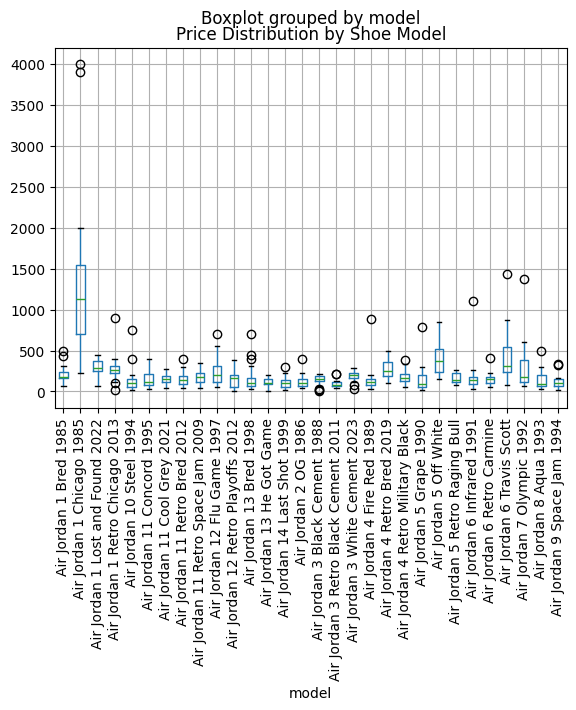

In [23]:
import matplotlib.pyplot as plt

plt.figure()
df.boxplot(column="price_numeric", by="model", rot=90)
plt.title("Price Distribution by Shoe Model")
plt.show()


Unique raw sell_date values:
<DatetimeArray>
['NaT']
Length: 1, dtype: datetime64[ns]

Valid sell_date count: 0
Sample sell_date values:
0   NaT
1   NaT
2   NaT
3   NaT
4   NaT
5   NaT
6   NaT
7   NaT
8   NaT
9   NaT
Name: sell_date, dtype: datetime64[ns]

Preview of weekly_model_prices:
Empty DataFrame
Columns: [model, week, mean_price]
Index: []


/var/folders/ns/nvqb8ykn4ln87vn4mwkshr2w0000gn/T/ipykernel_99554/3155745593.py:66: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")


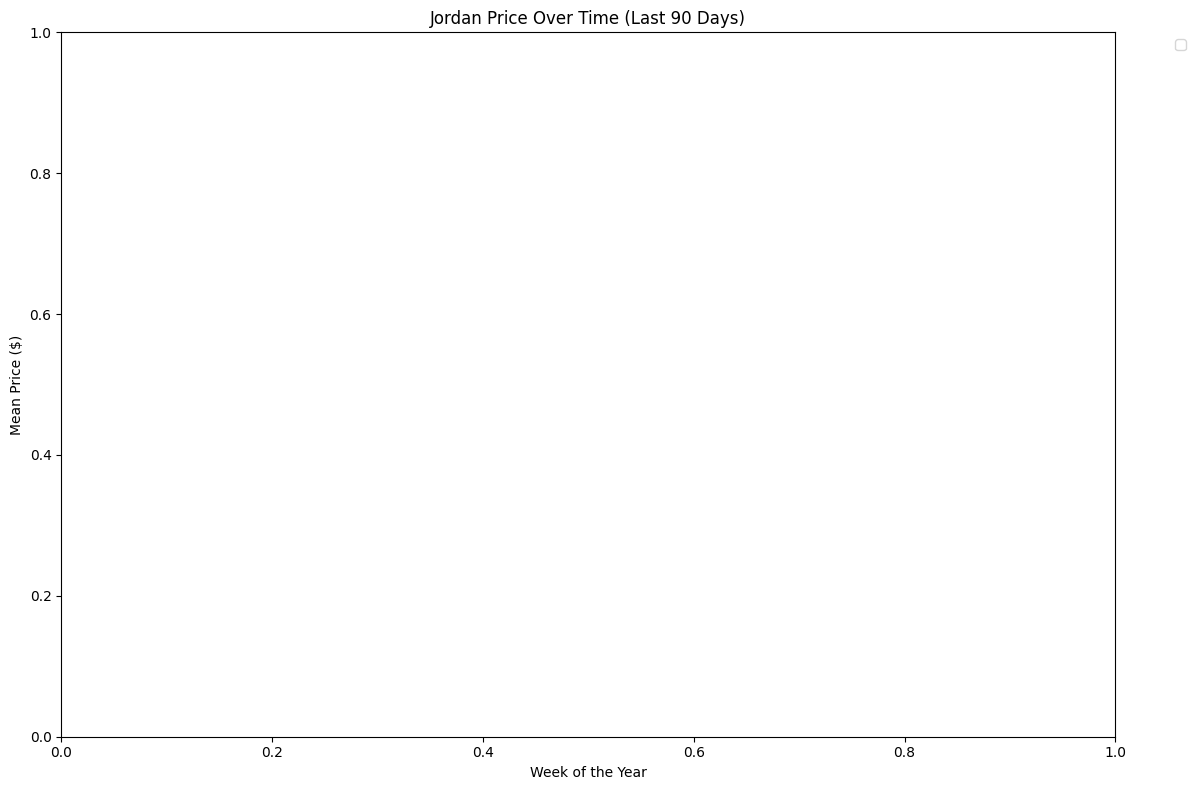

In [28]:
import re
import pandas as pd
import matplotlib.pyplot as plt

# Debug: print the unique values in the sell_date column
print("Unique raw sell_date values:")
print(df["sell_date"].unique())

#############################################
# 1) Parse Price to Numeric
#############################################
def parse_price(price_str):
    """
    Extract the first dollar amount from a price string (e.g., '$300' or '$69.99to$169.99')
    and convert it to a float.
    """
    match = re.search(r"\$([\d.,]+)", str(price_str))
    if match:
        return float(match.group(1).replace(",", ""))
    return None

df["price_numeric"] = df["price"].apply(parse_price)

#############################################
# 2) Convert sell_date to datetime with debugging
#############################################
# Convert sell_date to string and strip whitespace
df["sell_date"] = df["sell_date"].fillna("").astype(str).str.strip()
# Replace empty strings with None so that to_datetime can coerce them to NaT
df["sell_date"] = df["sell_date"].replace("", None)

# Try to convert to datetime; invalid or missing dates become NaT
df["sell_date"] = pd.to_datetime(df["sell_date"], errors="coerce")

# Debug: show how many valid dates we have
print("\nValid sell_date count:", df["sell_date"].notna().sum())
print("Sample sell_date values:")
print(df["sell_date"].head(10))

#############################################
# 3) Create a 'week' column from sell_date
#############################################
df["week"] = df["sell_date"].dt.isocalendar().week

#############################################
# 4) Group data by model and week, and compute mean price
#############################################
weekly_model_prices = (
    df.groupby(["model", "week"])["price_numeric"]
      .mean()
      .reset_index()
      .rename(columns={"price_numeric": "mean_price"})
)

print("\nPreview of weekly_model_prices:")
print(weekly_model_prices.head(20))

#############################################
# 5) Plot Each Model's Mean Price Over Weeks
#############################################
plt.figure(figsize=(12, 8))

for model_name, subdf in weekly_model_prices.groupby("model"):
    plt.plot(subdf["week"], subdf["mean_price"], marker="o", linestyle="-", label=model_name)

plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xlabel("Week of the Year")
plt.ylabel("Mean Price ($)")
plt.title("Jordan Price Over Time (Last 90 Days)")
plt.tight_layout()
plt.show()


In [29]:
# Save the DataFrame 'df' to a CSV file named 'jordan_data.csv'
df.to_csv("jordan_data.csv", index=False)


In [31]:
import jordanstreamlit



2025-03-16 17:42:59.060 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-16 17:42:59.060 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-16 17:42:59.061 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-16 17:42:59.061 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


KeyboardInterrupt: 